<a href="https://colab.research.google.com/github/jahabdank/mnist-digit-classifiers/blob/master/keras_mnist_digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras Mnist digit recognition

Original inspirational Keras code example can be found [here](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-mnist-cnn.ipynb#scrollTo=NkU7zrUm_307) and [here](https://colab.research.google.com/drive/1iTGGKIfxRRrhWpQQUqHdfVMrfqkdE0un)

The code uses built in keras.datasets.mnist functionality which automatically preloads all the necessary data for neural net training. Otherwise one needs to download the files and convert into numpy arrays self.

#### Before running
If running on Google Colab, remember to go to Runtime -> Change Runtime Type -> Select 'Python 3' and 'GPU'

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
import psutil
print(f"VM has {psutil.cpu_count()} cores, and {psutil.virtual_memory().free/1000000:.2f}MB free RAM (out of {psutil.virtual_memory().total/1000000:.2f} MB total), and {psutil.disk_usage('/').free/1000000:.2f}MB free Disk Space (out of {psutil.disk_usage('/').total/1000000:.2f} MB total)")

VM has 2 cores, and 9555.28MB free RAM (out of 13655.32 MB total), and 346247.93MB free Disk Space (out of 384691.15 MB total)


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(f'GPU device not found {device_name}')
else:
  print(f'Found GPU at: {device_name}')
  
# alternatively
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

Found GPU at: /device:GPU:0


## Data loading and visualisation

Load data and understand the structure of it, as well as display some examples as images.

In [0]:
# This call downloads the data from https://s3.amazonaws.com/img-datasets/mnist.npz
# and reads it as a numpy ndarray. It should be fairly easy to write such code, and thus use a different dataset.
# Note: .npz file extensinon is a numpy matrix file created by np.savez. If one would use any other type of dataset
# one would have to obviously download the file and load it manually into numpy arrays.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
# look at the shape and type of the data
describeNumpyArray = lambda name, ar: print(f"{name}: {type(ar)} of {type(ar.flatten()[0])}, with shape {ar.shape}")

describeNumpyArray('x_train', x_train)
describeNumpyArray('y_train', y_train)
describeNumpyArray('x_test', x_test)
describeNumpyArray('y_test', y_test)

x_train: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (60000, 28, 28)
y_train: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (60000,)
x_test: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (10000, 28, 28)
y_test: <class 'numpy.ndarray'> of <class 'numpy.uint8'>, with shape (10000,)


In [0]:
 %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# example of single plot
# plt.figure(figsize=(4,4))
# plt.grid(False)
# plt.axis('off')
# plt.imshow(x_train[0], cmap='gray')
# plt.title(f"Image of digit {y_train[0]}")

In [0]:
def plotImagesByIndex(indexes, x_set, y_set, y_pred = None):
  image_columns = 8
  image_rows = int(np.ceil(len(indexes)/image_columns))

  fig, m_axs = plt.subplots(image_rows, image_columns, figsize = (image_columns*3, image_rows*3))
  for i in range(0, len(indexes)):
    current_row = int(np.floor(i/image_columns))
    current_column = i%image_columns
    # print((current_row, current_column))
    m = m_axs[current_row][current_column]
    m.imshow(x_set[indexes[i]], cmap='gray')
    m.grid(False)
    m.axis('off')
    if y_pred is None:
      m.set_title(f"Label: {y_set[indexes[i]]}")
    else:
      m.set_title(f"Label: {y_set[indexes[i]]}, pred: {y_pred[indexes[i]]}")

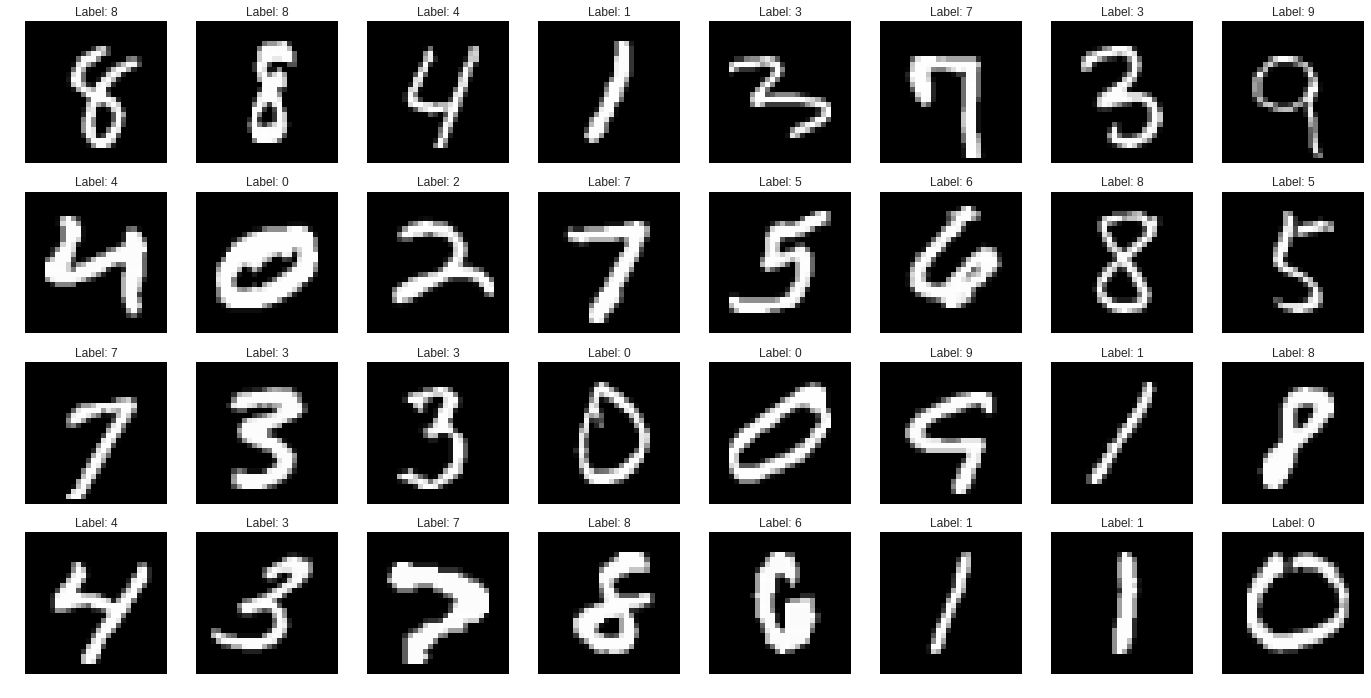

In [8]:
# Plot the digits
sample_size = 32
sample_indexes = np.random.choice(len(x_train), size=sample_size, replace=False)

plotImagesByIndex(sample_indexes, x_train, y_train)

## Data preprocessing

In [0]:
batch_size = 128
num_classes = 10
epochs = 10 # it already gets very good results after 10 epohs (> 99% accuracy on the train set), but normally one has more then 10. Originallt the value was 120

In [0]:
img_rows, img_cols = 28, 28

### reshaping the data with accordance on the Keras's needs

As Keras takes images with n channels, and these are greyscale images (no channel array), one has to add array with channels which in this case will be of length 1 (single channel per pixel)

In [11]:
print(f"K.image_data_format() = {K.image_data_format()}")
if K.image_data_format() == 'channels_first':
    x_train_k = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test_k = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_k = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test_k = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# convert to float32
x_train_k = x_train_k.astype('float32') 
x_test_k = x_test_k.astype('float32')

# normalize to one
x_train_k /= 255
x_test_k /= 255

K.image_data_format() = channels_last


In [12]:
describeNumpyArray('x_train_k', x_train_k)
describeNumpyArray('x_test_k', x_test_k)

x_train_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (60000, 28, 28, 1)
x_test_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (10000, 28, 28, 1)


### applying One Hot encoding to the output labels
[Wiki One-Hot Encoder](https://en.wikipedia.org/wiki/One-hot)

Converts a single labelled column into a vector of true/false columns saying true/false for each of the possibilities.

Example of encoding
* A color column with values: 'red', 'green', 'yellow'
* example: ['green', 'red', 'green', 'yellow']

Is encoded into:
* [[0 ,1, 0], [1 ,0, 0], [0 ,1, 0], [0, 0, 1]]

#### Note:
Some One-hot encoders could encode it into:
* [[0 ,1], [1 ,0], [0 ,1], [0, 0]]
with 'yellow' is encoded into [0,0], but not this one.

In [0]:
# One hot encoding
y_train_k = keras.utils.to_categorical(y_train, num_classes)
y_test_k = keras.utils.to_categorical(y_test, num_classes)

In [14]:
describeNumpyArray('y_train_k', y_train_k)
describeNumpyArray('y_test_k', y_test_k)

y_train_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (60000, 10)
y_test_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (10000, 10)


In [15]:
# just to visualize the output vectors after one hot encoding
y_train_k_df = pd.DataFrame(y_train_k[0:8])
y_train_k_df["OriginalLabel"] = y_train[y_train_k_df.index]
y_train_k_df

,0,1,2,3,4,5,6,7,8,9,OriginalLabel
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Creating the CNN

In [0]:
model = Sequential()

In [0]:
import tensorflow as tf 

### adding layers to the CNN

Layer types:

* The Convolution2D layers operate on 2D matrices so we input the digit images directly to the model.
* The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
* The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

Read more:
* [CNN Wiki](https://en.wikipedia.org/wiki/Convolutional_neural_network)
* [Relu Activation Function - Wiki](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
* [CNN Keras](https://keras.io/layers/convolutional/)
* [Pooling Keras](https://keras.io/layers/pooling/)

In [18]:
# Model V1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation=Activation(tf.nn.softmax)))

# # Model V2
# nb_classes = 10
# model.add(Conv2D(nb_filters, kernel_size=(3,3), padding='valid', input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(Conv2D(nb_filters, kernel_size))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(units=128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=nb_classes))
# model.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


### compiling the model

In [19]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1982592   
__________

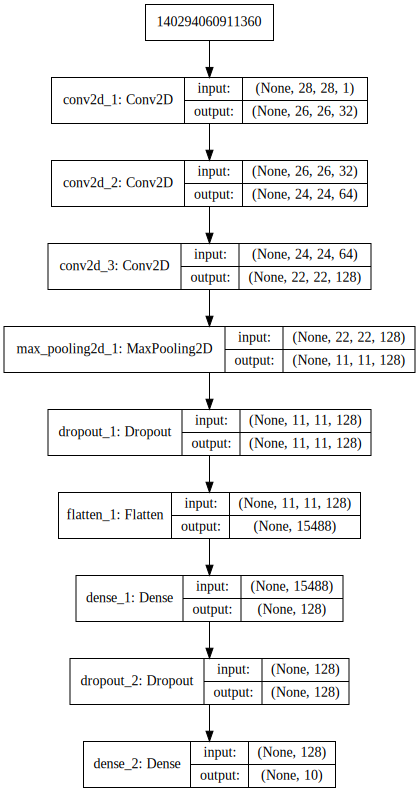

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### training the model

In [21]:
model.fit(x_train_k, y_train_k,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_k, y_test_k))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 19s 314us/step - loss: 0.2556 - acc: 0.9214 - val_loss: 0.0587 - val_acc: 0.9813
Epoch 2/10
60000/60000 [==============================] - 17s 286us/step - loss: 0.0786 - acc: 0.9763 - val_loss: 0.0393 - val_acc: 0.9879
Epoch 3/10
60000/60000 [==============================] - 17s 286us/step - loss: 0.0567 - acc: 0.9835 - val_loss: 0.0282 - val_acc: 0.9905
Epoch 4/10
60000/60000 [==============================] - 17s 286us/step - loss: 0.0457 - acc: 0.9867 - val_loss: 0.0315 - val_acc: 0.9897
Epoch 5/10
60000/60000 [==============================] - 17s 287us/step - loss: 0.0387 - acc: 0.9879 - val_loss: 0.0257 - val_acc: 0.9919
Epoch 6/10
60000/60000 [==============================] - 17s 286us/step - loss: 0.0340 - acc: 0.9899 - val_loss: 0.0247 - val_acc: 0.9912
Epoch 7/10
60000/60000 [==============================] - 17s 288us/step - loss: 0.0306 - acc: 0.9910 - val_loss: 0.

#### TODO: add saving and loading the model to google drive

### evaulating and viewing the result

In [22]:
score = model.evaluate(x_test_k, y_test_k, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.022897171927894852
Test accuracy: 0.993


In [0]:
pred = model.predict(x_test_k, verbose=0)
# as predictions are probabilities from 0 to 1 (but rarely exactly these values) one must apply decision threshold
# np.round applies a decision threshold at 0.5
pred_classified = np.round(pred)

# reverse One-Hot encoder. Note that it is not always that trivial :)
# it only works this time because the index of the column is the same as the value before the encoding
# in normal cases one has to train One-Hot encoder and the reverse it
pred_label = np.argmax(pred_classified, axis=1)

In [24]:
describeNumpyArray('x_test_k', y_test_k)
describeNumpyArray('pred', pred)
describeNumpyArray('pred_classified', pred_classified)
describeNumpyArray('pred_label', pred_label)

x_test_k: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (10000, 10)
pred: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (10000, 10)
pred_classified: <class 'numpy.ndarray'> of <class 'numpy.float32'>, with shape (10000, 10)
pred_label: <class 'numpy.ndarray'> of <class 'numpy.int64'>, with shape (10000,)


In [0]:
# find all indexes where the classification does not match the actual label 
# read anout np.all and np.any
misclasified_indexes = np.where((y_test_k != pred_classified).any(axis=1))[0]
clasified_indexes = np.where((y_test_k == pred_classified).all(axis=1))[0]

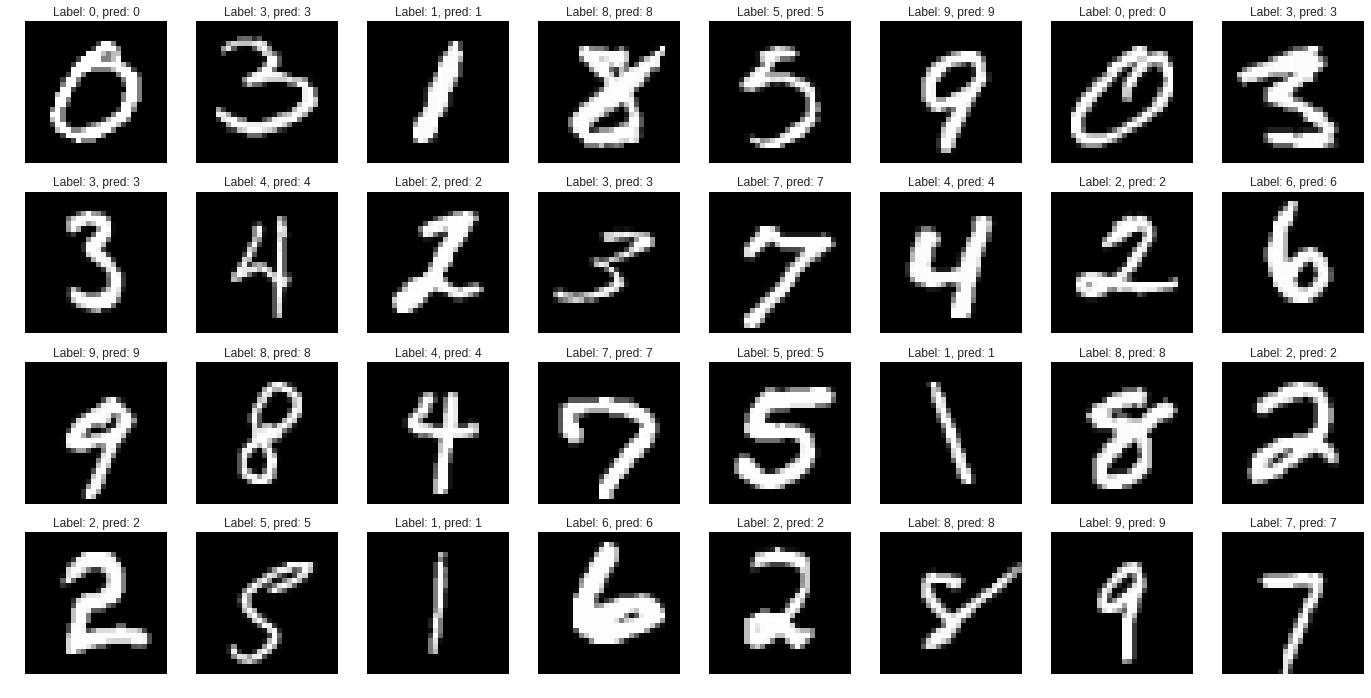

In [26]:
# Plot correctly classified indexes
plotImagesByIndex(clasified_indexes[np.random.choice(len(clasified_indexes), size=sample_size, replace=False)], x_test, y_test, pred_label)

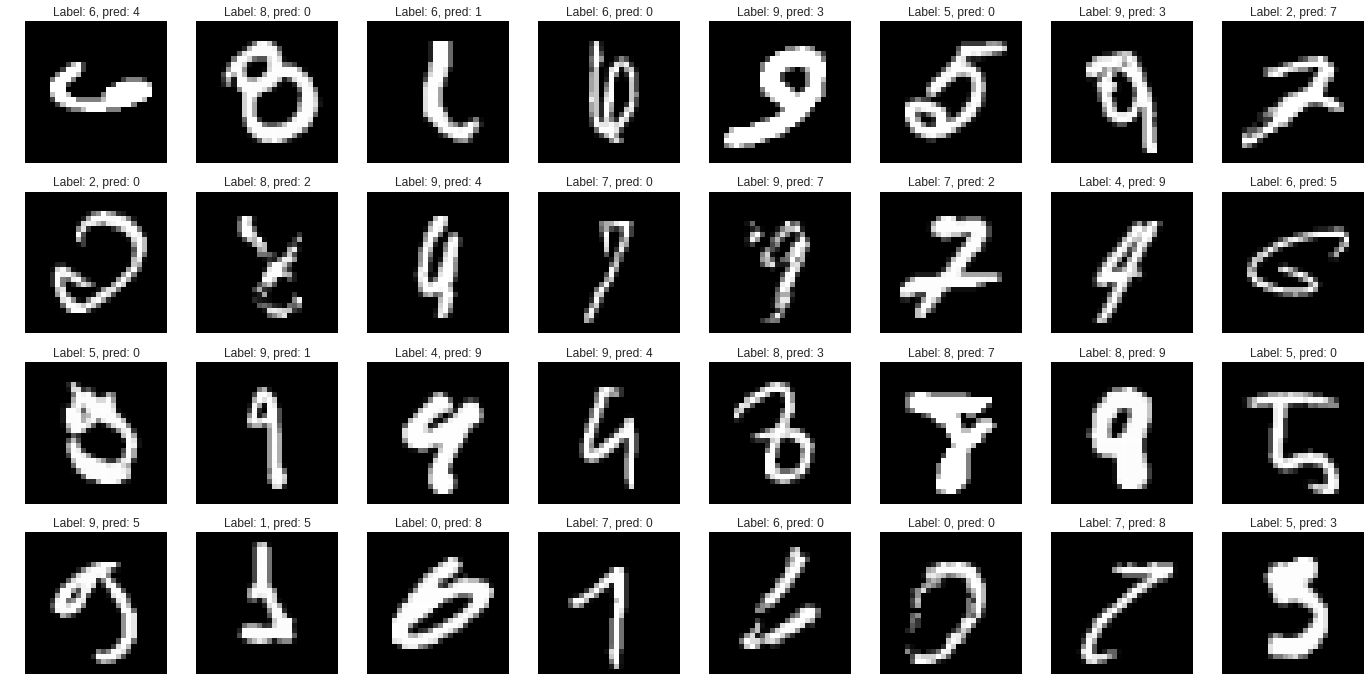

In [27]:
# Plot correctly classified indexes
plotImagesByIndex(misclasified_indexes[np.random.choice(len(misclasified_indexes), size=sample_size, replace=False)], x_test, y_test, pred_label)